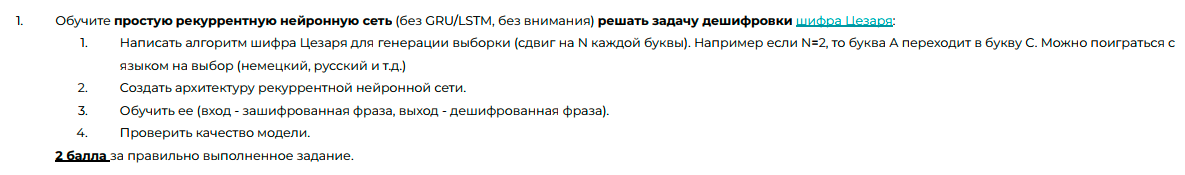

*Imports*

In [1]:
import torch
import time
import tqdm
import math
import numpy as np
#from random import shuffle

*Get datasets from Kaggle directly*

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files 

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"andreisech","key":"6a09802a1a7f4408fecb4407da2034f3"}'}

In [5]:
!mkdir ~/.kaggle 

In [6]:
!cp kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [8]:
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/world-population-dataset                     World Population Dataset                             17KB  2022-08-31 11:20:04          10636        316  1.0              
thedevastator/mcdonalds-ice-cream-machines-broken-timeseries   McDonalds Ice Cream Machines Breaking - Timeseries  404KB  2022-09-14 23:51:09           1063         40  1.0              
pantanjali/unemployment-dataset                                Unemployment dataset                                 17KB  2022-09-08 08:26:10           2834         80  1.0              
evangower/premier-league-match-data                            Pr

In [9]:
!kaggle datasets download 'fuzzyfroghunter/dickens'

 54% 5.00M/9.28M [00:00<00:00, 40.0MB/s]
100% 9.28M/9.28M [00:00<00:00, 67.4MB/s]


In [10]:
!mkdir corpus

In [11]:
!unzip dickens.zip -d corpus

Archive:  dickens.zip
  inflating: corpus/dickens/1289-0.txt  
  inflating: corpus/dickens/1400-0.txt  
  inflating: corpus/dickens/1467-0.txt  
  inflating: corpus/dickens/27924-0.txt  
  inflating: corpus/dickens/564-0.txt  
  inflating: corpus/dickens/580-0.txt  
  inflating: corpus/dickens/644-0.txt  
  inflating: corpus/dickens/650-0.txt  
  inflating: corpus/dickens/653-0.txt  
  inflating: corpus/dickens/675-0.txt  
  inflating: corpus/dickens/678-0.txt  
  inflating: corpus/dickens/700-0.txt  
  inflating: corpus/dickens/766-0.txt  
  inflating: corpus/dickens/786-0.txt  
  inflating: corpus/dickens/807-0.txt  
  inflating: corpus/dickens/882-0.txt  
  inflating: corpus/dickens/883-0.txt  
  inflating: corpus/dickens/914-0.txt  
  inflating: corpus/dickens/917-0.txt  
  inflating: corpus/dickens/924-0.txt  
  inflating: corpus/dickens/963-0.txt  
  inflating: corpus/dickens/967-0.txt  
  inflating: corpus/dickens/98-0.txt  
  inflating: corpus/dickens/metadata.tsv  
  inflating

*Global variables*

In [12]:
BATCH_SIZE = 10
STRING_SIZE = 60
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
FILE_NAME = "corpus/dickens/pg1023.txt"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CAESAR_OFFSET = 2
SOS_token = 0
EOS_token = 1

In [13]:
class CharVocabulary():

    def __init__(self):
        self.letters = ""

    def __len__(self):
        return len(self.letters)

    def __contains__(self, item):
        return item in self.letters

    def __getitem__(self, item):
        if isinstance(item, int):
            return self.letters[item % len(self.letters)]
        elif isinstance(item, str):
            return self.letters.find(item)

    def __str__(self):
        letters = " ".join(self.letters)
        return f"Alphabet is:\n {letters}\n {len(self)} chars"

    def load_from_file(self, file_path):
        with open(file_path) as file:
            while True:
                text = file.read(STRING_SIZE)
                text = text.lower()
                if not text:
                    break
                for ch in text:
                    if ch not in self.letters:
                        self.letters += ch
        return self

In [14]:
ALPHABET = CharVocabulary().load_from_file(FILE_NAME)
print(ALPHABET)

Alphabet is:
 ﻿ t h e   p r o j c g u n b k , l a s y d i 
 f w m v . - : 1 9 7 [ # 0 2 3 ] 6 4 ( ) * x q ' ! " 8 5 ; z ? & / % @ $
 59 chars


In [15]:
class SentenceDataset(torch.utils.data.Dataset):

    def __init__(self, raw_data, vocabulary):
        super().__init__()
        self._len = len(raw_data)
        self.y = torch.tensor([[vocabulary[ch] for ch in line] for line in raw_data]).to(DEVICE)
        self.x = torch.tensor([[i + CAESAR_OFFSET for i in line] for line in self.y]).to(DEVICE)
    
    def __len__(self):
        return self._len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [16]:
def get_text_array(file_path):
    text_array = []
    with open(file_path) as file:
        while True:
            text = file.read(STRING_SIZE)
            text = text.lower()
            if not text:
                break
            text_array.append(text)
    del text_array[-1]
    return text_array

In [17]:
#raw_data = get_text_array(FILE_NAME, STRING_SIZE)
#shuffle(raw_data)

raw_data = get_text_array(FILE_NAME)
valid_percent = 0.1
test_percent = 0.2
val_data = raw_data[:math.ceil(len(raw_data) * valid_percent)]
raw_data = raw_data[math.ceil(len(raw_data) * valid_percent):]
test_data = raw_data[:math.ceil(len(raw_data) * test_percent)]
train_data = raw_data[math.ceil(len(raw_data) * test_percent):]

train_data_loader = torch.utils.data.DataLoader(
    SentenceDataset(
        train_data, ALPHABET
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
test_data_loader = torch.utils.data.DataLoader(
    SentenceDataset(
        test_data, ALPHABET
    ),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

Y_val = torch.tensor([[ALPHABET[ch] for ch in line] for line in val_data])
X_val = torch.tensor([[i + CAESAR_OFFSET for i in line] for line in Y_val])

In [18]:
class RNNModel(torch.nn.Module):
    
    def __init__(self):
        super(RNNModel, self).__init__()
        self.embed = torch.nn.Embedding(len(ALPHABET) + CAESAR_OFFSET, 32)
        self.rnn = torch.nn.RNN(32, 128, batch_first=True)
        self.linear = torch.nn.Linear(128, len(ALPHABET) + CAESAR_OFFSET)

    def forward(self, sentence, state=None):
        embed = self.embed(sentence)
        o, h = self.rnn(embed)
        return self.linear(o)

In [19]:
model = RNNModel().to(DEVICE)
loss = torch.nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [20]:
for epoch in tqdm.trange(NUM_EPOCHS):
    train_loss, train_acc, iter_num = 0., 0., 0.
    start_epoch_time = time.time()
    model.train()
    for x, y in train_data_loader:
        y = y.view(1, -1).squeeze()
        optimizer.zero_grad()
        out = model(x).view(-1, len(ALPHABET) + CAESAR_OFFSET)
        l = loss(out, y)
        train_loss += l.item()
        batch_acc = (out.argmax(dim=1) == y)
        train_acc += batch_acc.sum().item() / batch_acc.shape[0]
        l.backward()
        optimizer.step()
        iter_num += 1
    print(
        f"Epoch: {epoch}, loss: {train_loss:.4f}, acc: "
        f"{train_acc / iter_num:.4f}", end=" | "
    )
    test_loss, test_acc, iter_num = 0., 0., 0.
    model.eval()
    for x, y in test_data_loader:
        y = y.view(1, -1).squeeze()
        out = model.forward(x).view(-1, len(ALPHABET) + CAESAR_OFFSET)
        l = loss(out, y)
        test_loss += l.item()
        batch_acc = (out.argmax(dim=1) == y)
        test_acc += batch_acc.sum().item() / batch_acc.shape[0]
        iter_num += 1
    print(
        f"test loss: {test_loss:.4f}, test acc: {test_acc / iter_num:.4f} | "
        f"{time.time() - start_epoch_time:.2f} sec."
    )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0, loss: 6823.9581, acc: 0.5897 | 

  5%|▌         | 1/20 [00:19<06:02, 19.09s/it]

test loss: 1110.6377, test acc: 0.7799 | 19.09 sec.
Epoch: 1, loss: 3187.0056, acc: 0.8006 | 

 10%|█         | 2/20 [00:37<05:40, 18.94s/it]

test loss: 570.5578, test acc: 0.8406 | 18.83 sec.
Epoch: 2, loss: 1813.1989, acc: 0.8896 | 

 15%|█▌        | 3/20 [00:56<05:22, 18.96s/it]

test loss: 358.1187, test acc: 0.9328 | 18.97 sec.
Epoch: 3, loss: 1189.0546, acc: 0.9450 | 

 20%|██        | 4/20 [01:15<05:03, 18.99s/it]

test loss: 246.6406, test acc: 0.9524 | 19.03 sec.
Epoch: 4, loss: 844.8182, acc: 0.9586 | 

 25%|██▌       | 5/20 [01:35<04:45, 19.06s/it]

test loss: 182.9720, test acc: 0.9634 | 19.18 sec.
Epoch: 5, loss: 642.5467, acc: 0.9665 | 

 30%|███       | 6/20 [01:54<04:29, 19.22s/it]

test loss: 144.0678, test acc: 0.9691 | 19.55 sec.
Epoch: 6, loss: 514.0754, acc: 0.9749 | 

 35%|███▌      | 7/20 [02:13<04:09, 19.22s/it]

test loss: 118.2775, test acc: 0.9804 | 19.22 sec.
Epoch: 7, loss: 426.0029, acc: 0.9846 | 

 40%|████      | 8/20 [02:33<03:50, 19.19s/it]

test loss: 99.9616, test acc: 0.9850 | 19.12 sec.
Epoch: 8, loss: 362.0049, acc: 0.9869 | 

 45%|████▌     | 9/20 [02:51<03:30, 19.12s/it]

test loss: 86.3338, test acc: 0.9862 | 18.95 sec.
Epoch: 9, loss: 313.6353, acc: 0.9878 | 

 50%|█████     | 10/20 [03:11<03:11, 19.16s/it]

test loss: 75.8749, test acc: 0.9869 | 19.24 sec.
Epoch: 10, loss: 276.1912, acc: 0.9884 | 

 55%|█████▌    | 11/20 [03:32<02:58, 19.79s/it]

test loss: 67.6416, test acc: 0.9873 | 21.21 sec.
Epoch: 11, loss: 246.7401, acc: 0.9888 | 

 60%|██████    | 12/20 [03:51<02:36, 19.57s/it]

test loss: 61.1380, test acc: 0.9881 | 19.07 sec.
Epoch: 12, loss: 223.2431, acc: 0.9899 | 

 65%|██████▌   | 13/20 [04:10<02:16, 19.48s/it]

test loss: 55.8842, test acc: 0.9893 | 19.28 sec.
Epoch: 13, loss: 204.2028, acc: 0.9905 | 

 70%|███████   | 14/20 [04:30<01:58, 19.67s/it]

test loss: 51.5558, test acc: 0.9895 | 20.11 sec.
Epoch: 14, loss: 188.5098, acc: 0.9906 | 

 75%|███████▌  | 15/20 [04:51<01:39, 19.83s/it]

test loss: 47.9443, test acc: 0.9895 | 20.19 sec.
Epoch: 15, loss: 175.3518, acc: 0.9906 | 

 80%|████████  | 16/20 [05:10<01:18, 19.66s/it]

test loss: 44.8900, test acc: 0.9895 | 19.26 sec.
Epoch: 16, loss: 164.1374, acc: 0.9906 | 

 85%|████████▌ | 17/20 [05:29<00:58, 19.53s/it]

test loss: 42.2560, test acc: 0.9895 | 19.22 sec.
Epoch: 17, loss: 154.4364, acc: 0.9909 | 

 90%|█████████ | 18/20 [05:48<00:38, 19.37s/it]

test loss: 39.9482, test acc: 0.9902 | 19.00 sec.
Epoch: 18, loss: 145.9323, acc: 0.9914 | 

 95%|█████████▌| 19/20 [06:07<00:19, 19.27s/it]

test loss: 37.9208, test acc: 0.9903 | 19.04 sec.
Epoch: 19, loss: 138.3887, acc: 0.9914 | 

100%|██████████| 20/20 [06:26<00:00, 19.33s/it]

test loss: 36.0875, test acc: 0.9904 | 19.05 sec.


## Inference

In [23]:
# sample validation
idx = 256
val_results = model(X_val.to(DEVICE)).argmax(dim=2)
val_acc = (val_results == Y_val.to(DEVICE)).flatten()
val_acc = (val_acc.sum() / val_acc.shape[0]).item()
out_sentence = "".join([ALPHABET[i.item()] for i in val_results[idx]])
true_sentence = "".join([ALPHABET[i.item()] for i in Y_val[idx]])

print(f"Validation accuracy is : {val_acc:.4f}")
print("-" * 100)
print(f"Validation sentence is: \"{out_sentence}\"")
print("-" * 100)
print(f"True sentence is:       \"{true_sentence}\"")

Validation accuracy is : 0.9901
----------------------------------------------------------------------------------------------------
Validation sentence is: "t no two chancery lawyers can talk about it for five
minutes"
----------------------------------------------------------------------------------------------------
True sentence is:       "t no two chancery lawyers can talk about it for five
minutes"


In [24]:
# Sentence from difference source (Harry Potter book) to validate
sentence = """Mr Ollivander touched the lightning scar on Harry’s forehead with a long, white finger. ‘I’m sorry to say I sold the wand that did it,’ he said softly. ‘Thirteen and a half inches. Yew. Powerful wand, very powerful, and in the wrong hands … Well, if I’d known what that wand was going out into the world to do’""".lower()
sentence_idx = [ALPHABET[i] for i in sentence]
encrypted_sentence_idx = [i + CAESAR_OFFSET for i in sentence_idx]
encrypted_sentence = "".join([ALPHABET[i] for i in encrypted_sentence_idx])
result = model(torch.tensor([encrypted_sentence_idx]).to(DEVICE)).argmax(dim=2)
deencrypted_sentence = "".join([ALPHABET[i.item()] for i in result.flatten()])
print("Encrypted sentence is : {}".format(encrypted_sentence))
print("-" * 100)
print("Deencrypted sentence is : {}".format(deencrypted_sentence))

Encrypted sentence is : .jrcssf-yk
pjrecbu p
re prsfn ekfknrduyjrckr yjjitdrmcjp py
rvfe ryrscknarv feprmfknpj:rtft.rdcjjirecrdyirfrdcs
re prvyk
re yer
f
rfeatr prdyf
rdcmesi:rte fjeppkryk
ryr ysmrfku pd:ripv:rocvpjmbsrvyk
ar-pjirocvpjmbsaryk
rfkre prvjcknr yk
drtrvpssarfmrft
rlkcvkrv yere yervyk
rvydrncfknrcberfkecre prvcjs
recr
ct
----------------------------------------------------------------------------------------------------
Deencrypted sentence is : mr ollivander touched the lightning scar on harryss forehead with a long, white finger. sism sorry to say i sold the wand that did it,s he said softly. sthirteen and a half inches. yew. powerful wand, very powerful, and in the wrong hands s well, if isd known what that wand was going out into the world to dos


As we can see simple RNN to decode Caesar's code has good enough accuracy, but it failed sometime to decode unknown text if new characters appeared (not appeared in training corpus)

## Calculation metric on validation dataset

Because we have char-level sentence the simplest QA estimation method is to match actual and predicted characters

In [27]:
# Calculate accuracy on full validation dataset
scores = []

for x, y in zip(X_val, Y_val):
    y = y.view(1, -1).squeeze()
    out = model.forward(x).view(-1, len(ALPHABET) + CAESAR_OFFSET)
    val_acc = (out.argmax(dim=1) == y)
    scores.append(val_acc.sum().item() / val_acc.shape[0])

print('Accuracy is {:0.4f}'.format(np.mean(scores)))

Accuracy is 0.9901
